In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-segmentation-dataset/Online Retail.xlsx


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Dataset
df = pd.read_excel('/kaggle/input/customer-segmentation-dataset/Online Retail.xlsx')
print(df.head(5))

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [4]:
# dataset select 
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
data = df.dropna(subset=['CustomerID'])
data['CustomerID'] = data['CustomerID'].astype(int)

**Exploratory Data Analysis(EDA)** 

In [6]:
data.shape

(406829, 8)

In [7]:
data.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,406829.000000,406829,406829.000000,406829.000000
mean,12.061303,2011-07-10 16:30:57.879207168,3.460471,15287.690570
min,-80995.000000,2010-12-01 08:26:00,0.000000,12346.000000
25%,2.000000,2011-04-06 15:02:00,1.250000,13953.000000
50%,5.000000,2011-07-31 11:48:00,1.950000,15152.000000
75%,12.000000,2011-10-20 13:06:00,3.750000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,248.693370,NaN,69.315162,1713.600303


In [8]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  int64         
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 27.9+ MB
None


**Feature Engineering (RFM Calucation)**


In [9]:
# Feature Engineering

data['TotalAmount'] = data['Quantity'] * data['UnitPrice']
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

#snapshot Date(refernce_date)
reference_date = data['InvoiceDate'].max() + pd.Timedelta(days=1)

#rfm cacluations
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate':lambda x:(reference_date - x.max()).days, # Recency
    'CustomerID' :'count',                                  # Frequency
    'TotalAmount': 'sum'                                    # Monetary
})

# rename 
rfm.rename(columns={'InvoiceDate':'Recency','CustomerID':'Frequency','TotalAmount':'Monetary'}, inplace=True)
print(rfm.head())

            Recency  Frequency  Monetary
CustomerID                              
12346           326          2      0.00
12347             2        182   4310.00
12348            75         31   1797.24
12349            19         73   1757.55
12350           310         17    334.40


In [10]:
# Standard Sclaer
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency','Frequency','Monetary']])

**Elbow Method and Visual Plot**

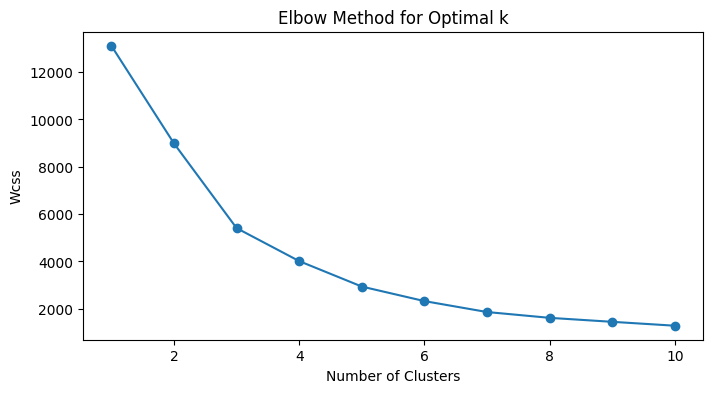

In [11]:
# Now we check the how many Clusters to take
from sklearn.cluster import KMeans

wcss = []   # Within- Cluster Sum of Squares (WCSS)
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)


# Clusters Visuals

plt.figure(figsize=(8,4))
plt.plot(range(1,11),wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Wcss')
plt.show()

**Applying KMeans Clustering**

In [12]:
Kmeans = KMeans(n_clusters = 4, random_state=42)

rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [13]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(rfm_scaled)

# Add cluster labels to RFM table
rfm['Cluster'] = kmeans.labels_

In [14]:
# check the cluster size
print(rfm['Cluster'].value_counts())

Cluster
0    3050
2    1072
3     241
1       5
4       4
Name: count, dtype: int64


**Data Visualizations**


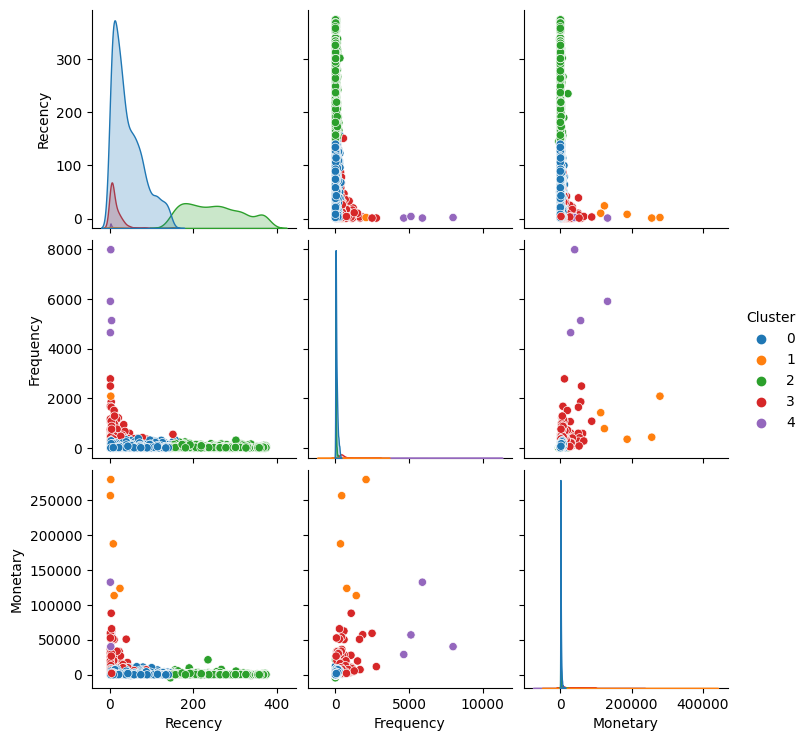

In [15]:
# pairplot Visualization
sns.pairplot(rfm, hue='Cluster', vars=['Recency','Frequency','Monetary'], palette='tab10')
plt.show()

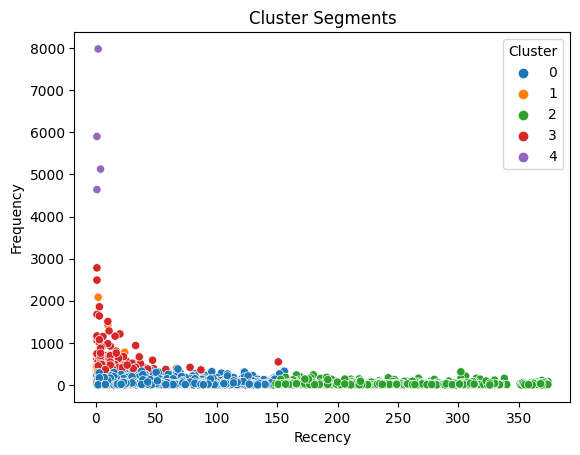

In [16]:
# visual of Clusters(scatter plot)
sns.scatterplot(data=rfm, x='Recency',y='Frequency',hue='Cluster', palette='tab10')
plt.title('Cluster Segments')
plt.show()

**Customer Segments By PCA**

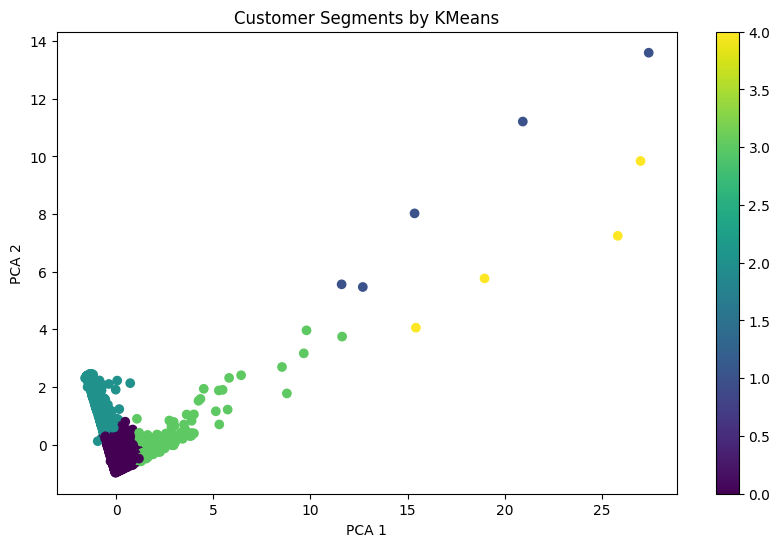

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(rfm_scaled)


#Scatter Visuals
plt.figure(figsize=(10,6))
#plt.scatter(components[:,0], components[:,1], c=rfm['Cluster'], cmap='viridis')
plt.scatter(components[:, 0], components[:, 1], c=rfm['Cluster'], cmap='viridis')
plt.title('Customer Segments by KMeans')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar()
plt.show()